Occupancy Detection based on ECO dataset: Winter
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [2]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

The following function calculates the sad: 

In [5]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

The following function detects the on-off status:

In [6]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

In [7]:
from os import walk
path = "C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_sm_csv/01"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [8]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

245

In [9]:
df2 = pd.read_csv("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_occupancy_csv/01_winter.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

46

In [10]:
import datetime
winter = df2.index.tolist()
df_winter = {}
for key in df.keys():
    if key in winter:
        df_winter[key]=df[key]
len(df_winter)

46

In [ ]:
n = 900  #chunk row size
winter_features = pd.DataFrame()
for day, data in df_winter.items():
    list_df_winter = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_winter:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
    
    winter_features = winter_features.append(data)
winter_features.loc[winter_features.ptime < 25, 'ptime'] = 0
winter_features.loc[winter_features.ptime > 89, 'ptime'] = 0
winter_features = winter_features.loc[(winter_features['ptime'] >0)]
winter_features['ptime'] = winter_features['ptime'] - 24

winter_features

In [12]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_winter = []
    list_oc_winter = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_winter:
        occ_winter.append(np.bincount(chunk).argmax())
    occ_winter = occ_winter[24:89]

    cuml_list.extend(occ_winter)
#     print(len(cuml_list))
occ_winter_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
print(occ_winter_data)  
    

      occupancy
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1
10            1
11            1
12            1
13            1
14            1
15            1
16            1
17            1
18            1
19            1
20            1
21            1
22            1
23            1
24            1
25            0
26            0
27            0
28            0
29            0
...         ...
2505          1
2506          1
2507          1
2508          1
2509          1
2510          1
2511          1
2512          1
2513          1
2514          1
2515          1
2516          1
2517          1
2518          1
2519          1
2520          1
2521          1
2522          1
2523          1
2524          1
2525          1
2526          1
2527          1
2528          1
2529          1
2530          1
2531          1
2532          1
2533          1
2534          1

[2535 r

Replacing all the 'nan' values by '0'

In [13]:
winter_features[np.isnan(winter_features)] = 0

Model with Manual Validation:
-----------

In [14]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

Data Pre-processing:


In [15]:
X = np.array(winter_features)
print('X dim: ',X.shape)
y = np.array(occ_winter_data)
print('y dim: ',y.shape)

X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_tesy dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_tesy dim: ', y_test.shape)

X dim:  (2535, 33)
y dim:  (2535, 1)
X_train dim:  (2154, 33, 1)
X_tesy dim:  (381, 33, 1)
y_train dim:  (2154, 1)
y_tesy dim:  (381, 1)


In [16]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

W0828 14:49:29.160645  3952 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 14:49:29.180646  3952 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 14:49:29.183646  3952 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 14:49:29.255650  3952 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 14:49:29.273652  3952 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 33, 64)            32832     
__________

Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 4s - loss: 0.6630 - acc: 0.6773 - val_loss: 0.5836 - val_acc: 0.7717
Epoch 2/150
 - 2s - loss: 0.5050 - acc: 0.7748 - val_loss: 0.4367 - val_acc: 0.7927
Epoch 3/150
 - 2s - loss: 0.4620 - acc: 0.7957 - val_loss: 0.4459 - val_acc: 0.8005
Epoch 4/150
 - 2s - loss: 0.4443 - acc: 0.7920 - val_loss: 0.4165 - val_acc: 0.8136
Epoch 5/150
 - 2s - loss: 0.4353 - acc: 0.7971 - val_loss: 0.4660 - val_acc: 0.8268
Epoch 6/150
 - 2s - loss: 0.4162 - acc: 0.8148 - val_loss: 0.3852 - val_acc: 0.8163
Epoch 7/150
 - 2s - loss: 0.3940 - acc: 0.8171 - val_loss: 0.3905 - val_acc: 0.8110
Epoch 8/150
 - 2s - loss: 0.4044 - acc: 0.8120 - val_loss: 0.3781 - val_acc: 0.8031
Epoch 9/150
 - 2s - loss: 0.3992 - acc: 0.8143 - val_loss: 0.3647 - val_acc: 0.8241
Epoch 10/150
 - 2s - loss: 0.3930 - acc: 0.8078 - val_loss: 0.3476 - val_acc: 0.8268
Epoch 11/150
 - 2s - loss: 0.3806 - acc: 0.8171 - val_loss: 0.3625 - val_acc: 0.8215
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 2s - loss: 0.2548 - acc: 0.8890 - val_loss: 0.3704 - val_acc: 0.8504
Epoch 98/150
 - 2s - loss: 0.2581 - acc: 0.8867 - val_loss: 0.3625 - val_acc: 0.8451
Epoch 99/150
 - 2s - loss: 0.2700 - acc: 0.8835 - val_loss: 0.3532 - val_acc: 0.8478
Epoch 100/150
 - 2s - loss: 0.2481 - acc: 0.8904 - val_loss: 0.3569 - val_acc: 0.8425
Epoch 101/150
 - 2s - loss: 0.2617 - acc: 0.8858 - val_loss: 0.3631 - val_acc: 0.8583
Epoch 102/150
 - 2s - loss: 0.2628 - acc: 0.8825 - val_loss: 0.3761 - val_acc: 0.8346
Epoch 103/150
 - 2s - loss: 0.2527 - acc: 0.8858 - val_loss: 0.3536 - val_acc: 0.8635
Epoch 104/150
 - 2s - loss: 0.2554 - acc: 0.8853 - val_loss: 0.3551 - val_acc: 0.8530
Epoch 105/150
 - 2s - loss: 0.2535 - acc: 0.8867 - val_loss: 0.3497 - val_acc: 0.8556
Epoch 106/150
 - 2s - loss: 0.2568 - acc: 0.8844 - val_loss: 0.3497 - val_acc: 0.8556
Epoch 107/150
 - 2s - loss: 0.2608 - acc: 0.8890 - val_loss: 0.3571 - val_acc: 0.8399
Epoch 108/150
 - 2s - loss: 0.2498 - acc: 0.8909 - val_lo

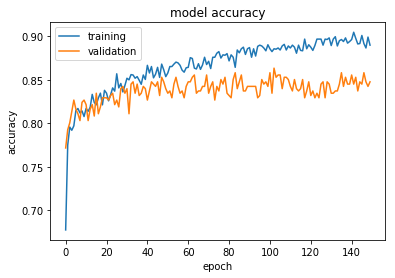

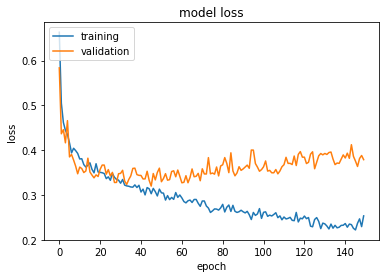

In [17]:
history = LossHistory()
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

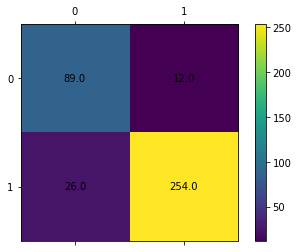

In [29]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test,y_test)

Classification error: 84.78

Early Stopping:
------

In [34]:
model = init_model(features)

Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 7s - loss: 0.6773 - acc: 0.6787 - val_loss: 0.6660 - val_acc: 0.7165
Epoch 2/150
 - 3s - loss: 0.5318 - acc: 0.7586 - val_loss: 0.4953 - val_acc: 0.7874
Epoch 3/150
 - 3s - loss: 0.4861 - acc: 0.7790 - val_loss: 0.5245 - val_acc: 0.7717
Epoch 4/150
 - 3s - loss: 0.4543 - acc: 0.7916 - val_loss: 0.4042 - val_acc: 0.8110
Epoch 5/150
 - 3s - loss: 0.4366 - acc: 0.7953 - val_loss: 0.4222 - val_acc: 0.8031
Epoch 6/150
 - 3s - loss: 0.4258 - acc: 0.7939 - val_loss: 0.4032 - val_acc: 0.8084
Epoch 7/150
 - 3s - loss: 0.4016 - acc: 0.8143 - val_loss: 0.3660 - val_acc: 0.8215
Epoch 8/150
 - 3s - loss: 0.3956 - acc: 0.8101 - val_loss: 0.3867 - val_acc: 0.7979
Epoch 9/150
 - 3s - loss: 0.3865 - acc: 0.8143 - val_loss: 0.3543 - val_acc: 0.8268
Epoch 10/150
 - 3s - loss: 0.3955 - acc: 0.8194 - val_loss: 0.3678 - val_acc: 0.8084
Epoch 11/150
 - 3s - loss: 0.3825 - acc: 0.8171 - val_loss: 0.3592 - val_acc: 0.8110
Epoch 12/150
 - 3s - loss: 

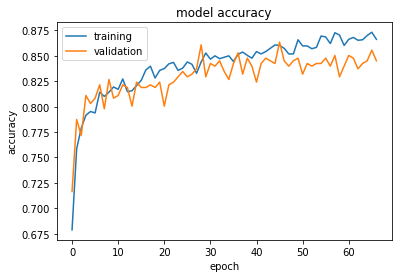

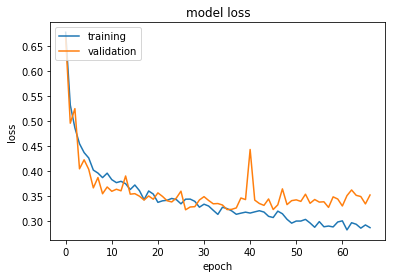

In [35]:
history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history,es],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

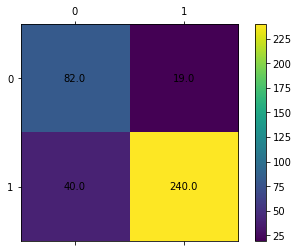

In [36]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test,y_test)

Model with K-fold Validation:
----------

acc: 83.47%


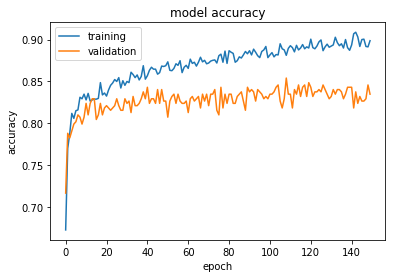

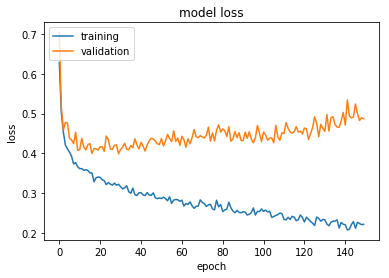

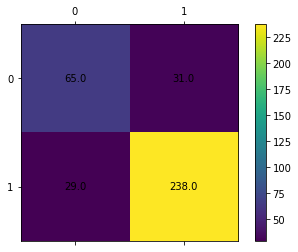

acc: 85.91%


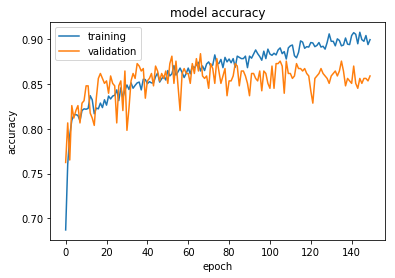

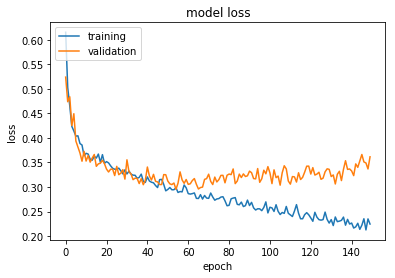

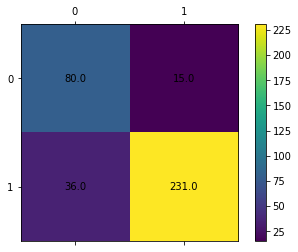

acc: 82.87%


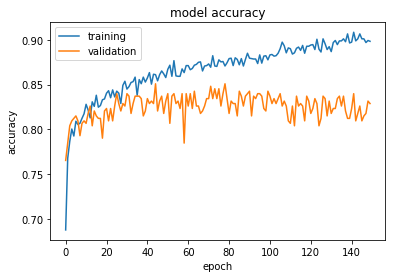

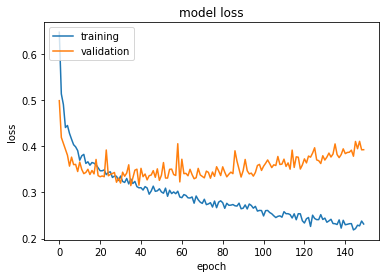

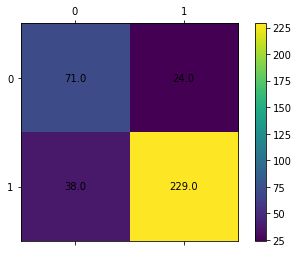

acc: 85.64%


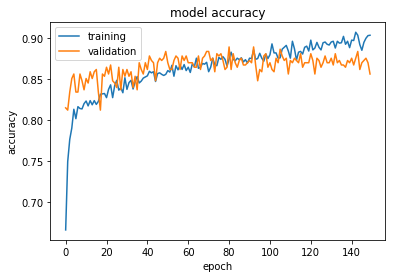

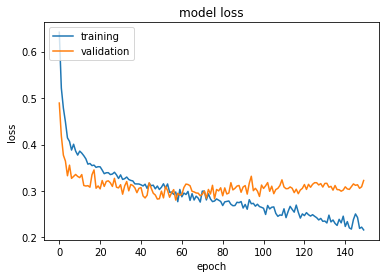

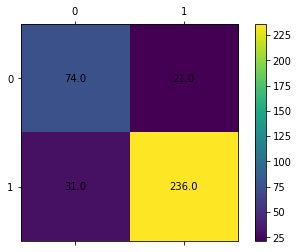

acc: 84.53%


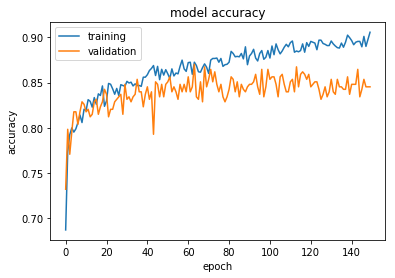

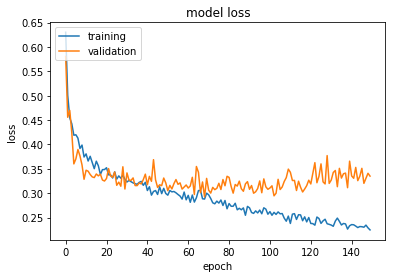

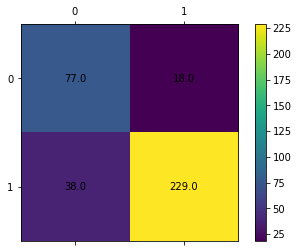

acc: 84.81%


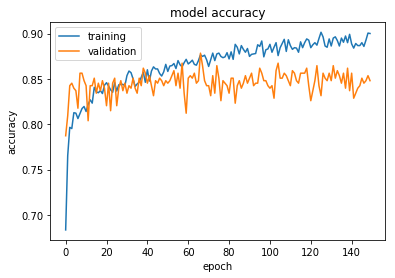

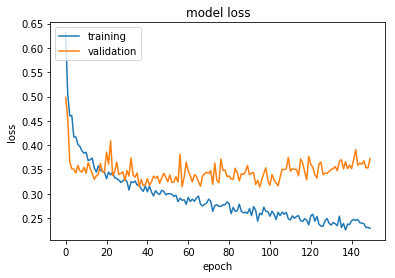

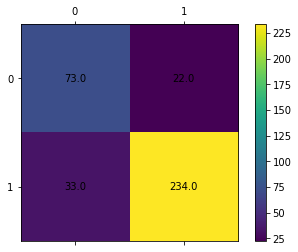

acc: 88.12%


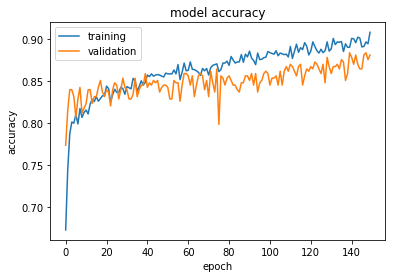

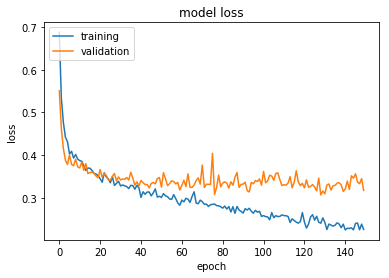

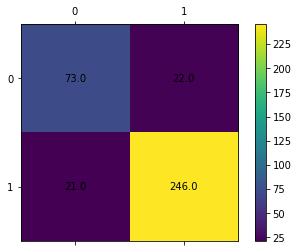

NameError: name 'numpy' is not defined

In [30]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
loss = []
for train, test in kfold.split(X, y):
    
    model = init_model(features)
    
    X_train_k =X[train].reshape(X[train].shape[0], X[train].shape[1], 1)
    X_test_k = X[test].reshape(X[test].shape[0], X[test].shape[1], 1)
    history = LossHistory()
    hiss = model.fit(X_train_k, y[train], epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test_k,y[test]), verbose=0)
    scores = model.evaluate(X_test_k, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    loss.append(scores[0])
#     print(score)
    plt.plot(hiss.history['acc'])
    plt.plot(hiss.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss.history['loss'])
    plt.plot(hiss.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_k,y[test])


In [33]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss), np.std(loss)))

accuracy::  85.05% (+/- 1.61%)
error:: 0.37 (+/- 0.05)


Shapely Values:
-------

In [41]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(2154, 33, 1)

In [ ]:
model = init_model(features)
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

In [ ]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

In [ ]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

In [ ]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

In [ ]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely Values
-------------

In [354]:
new_winter_features= X[:,0:14]
new_winter_features = np.concatenate((new_winter_features, X[:,15:22], X[:,23:33]),axis=1)
new_winter_features.shape


(2535, 31)

In [356]:
X_train1 =new_winter_features[0:2200,:]
X_test1 = new_winter_features[2200:2535,:]

X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)
X_test1.shape[1]

31

In [357]:
model = init_model(X_train1.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 31, 16)            80        
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 16)            64        
_________________________________________________________________
dropout_212 (Dropout)        (None, 31, 16)            0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 496)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 128)               63616     
_________________________________________________________________
dropout_213 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 129       
__________

Train on 2200 samples, validate on 335 samples
Epoch 1/500
 - 11s - loss: 3.4118 - acc: 0.6464 - val_loss: 0.4766 - val_acc: 0.7075
Epoch 2/500
 - 0s - loss: 3.2815 - acc: 0.6468 - val_loss: 0.4390 - val_acc: 0.7164
Epoch 3/500
 - 0s - loss: 3.1448 - acc: 0.6795 - val_loss: 0.4196 - val_acc: 0.7612
Epoch 4/500
 - 0s - loss: 3.2152 - acc: 0.6486 - val_loss: 0.3811 - val_acc: 0.8358
Epoch 5/500
 - 0s - loss: 3.5209 - acc: 0.6423 - val_loss: 0.5284 - val_acc: 0.6627
Epoch 6/500
 - 0s - loss: 3.2996 - acc: 0.6691 - val_loss: 0.4293 - val_acc: 0.7522
Epoch 7/500
 - 0s - loss: 3.3381 - acc: 0.6568 - val_loss: 0.4593 - val_acc: 0.7254
Epoch 8/500
 - 0s - loss: 3.5910 - acc: 0.6655 - val_loss: 0.5300 - val_acc: 0.6896
Epoch 9/500
 - 0s - loss: 3.3724 - acc: 0.6705 - val_loss: 0.4396 - val_acc: 0.7463
Epoch 10/500
 - 0s - loss: 3.2287 - acc: 0.6823 - val_loss: 0.3831 - val_acc: 0.7731
Epoch 11/500
 - 0s - loss: 3.2393 - acc: 0.6905 - val_loss: 0.3819 - val_acc: 0.7612
Epoch 12/500
 - 0s - loss:

Epoch 97/500
 - 0s - loss: 3.3891 - acc: 0.6841 - val_loss: 0.5809 - val_acc: 0.6776
Epoch 98/500
 - 0s - loss: 3.2023 - acc: 0.7014 - val_loss: 0.4424 - val_acc: 0.7343
Epoch 99/500
 - 0s - loss: 3.4979 - acc: 0.6827 - val_loss: 0.4203 - val_acc: 0.7821
Epoch 100/500
 - 0s - loss: 3.3242 - acc: 0.6905 - val_loss: 0.4388 - val_acc: 0.7522
Epoch 101/500
 - 0s - loss: 3.0831 - acc: 0.7036 - val_loss: 0.4603 - val_acc: 0.7015
Epoch 102/500
 - 0s - loss: 3.1657 - acc: 0.7045 - val_loss: 0.4248 - val_acc: 0.7731
Epoch 103/500
 - 0s - loss: 3.3011 - acc: 0.6936 - val_loss: 0.4210 - val_acc: 0.7701
Epoch 104/500
 - 0s - loss: 3.4272 - acc: 0.6782 - val_loss: 0.4372 - val_acc: 0.7433
Epoch 105/500
 - 0s - loss: 3.3062 - acc: 0.6945 - val_loss: 0.4078 - val_acc: 0.7791
Epoch 106/500
 - 0s - loss: 3.4099 - acc: 0.6918 - val_loss: 0.4576 - val_acc: 0.7313
Epoch 107/500
 - 0s - loss: 3.2791 - acc: 0.6927 - val_loss: 0.4224 - val_acc: 0.7642
Epoch 108/500
 - 0s - loss: 3.4032 - acc: 0.6964 - val_lo

Epoch 193/500
 - 0s - loss: 3.0301 - acc: 0.7268 - val_loss: 0.4219 - val_acc: 0.8119
Epoch 194/500
 - 0s - loss: 3.2324 - acc: 0.7132 - val_loss: 0.4397 - val_acc: 0.7881
Epoch 195/500
 - 0s - loss: 3.2718 - acc: 0.7123 - val_loss: 0.4415 - val_acc: 0.7910
Epoch 196/500
 - 0s - loss: 3.3233 - acc: 0.7041 - val_loss: 0.4626 - val_acc: 0.7731
Epoch 197/500
 - 1s - loss: 3.1756 - acc: 0.7095 - val_loss: 0.4446 - val_acc: 0.7970
Epoch 198/500
 - 0s - loss: 3.3028 - acc: 0.7050 - val_loss: 0.4449 - val_acc: 0.7940
Epoch 199/500
 - 0s - loss: 3.3219 - acc: 0.7077 - val_loss: 0.4789 - val_acc: 0.7582
Epoch 200/500
 - 0s - loss: 3.1490 - acc: 0.7245 - val_loss: 0.5269 - val_acc: 0.7134
Epoch 201/500
 - 0s - loss: 3.3084 - acc: 0.7009 - val_loss: 0.4474 - val_acc: 0.7940
Epoch 202/500
 - 0s - loss: 3.2863 - acc: 0.7109 - val_loss: 0.4695 - val_acc: 0.7761
Epoch 203/500
 - 0s - loss: 3.2591 - acc: 0.7118 - val_loss: 0.4402 - val_acc: 0.7970
Epoch 204/500
 - 0s - loss: 3.3505 - acc: 0.7068 - val

Epoch 289/500
 - 0s - loss: 3.0093 - acc: 0.7332 - val_loss: 0.4367 - val_acc: 0.8149
Epoch 290/500
 - 0s - loss: 3.2955 - acc: 0.7123 - val_loss: 0.4593 - val_acc: 0.7761
Epoch 291/500
 - 0s - loss: 3.1955 - acc: 0.7286 - val_loss: 0.4236 - val_acc: 0.8179
Epoch 292/500
 - 0s - loss: 3.1087 - acc: 0.7209 - val_loss: 0.4573 - val_acc: 0.7910
Epoch 293/500
 - 0s - loss: 3.1630 - acc: 0.7173 - val_loss: 0.4233 - val_acc: 0.8090
Epoch 294/500
 - 0s - loss: 3.0833 - acc: 0.7291 - val_loss: 0.4554 - val_acc: 0.7761
Epoch 295/500
 - 0s - loss: 3.3737 - acc: 0.7068 - val_loss: 0.4454 - val_acc: 0.7940
Epoch 296/500
 - 0s - loss: 3.3492 - acc: 0.7095 - val_loss: 0.4403 - val_acc: 0.7970
Epoch 297/500
 - 0s - loss: 3.1881 - acc: 0.7259 - val_loss: 0.4329 - val_acc: 0.8149
Epoch 298/500
 - 0s - loss: 3.2830 - acc: 0.7132 - val_loss: 0.4503 - val_acc: 0.8030
Epoch 299/500
 - 0s - loss: 3.2574 - acc: 0.7191 - val_loss: 0.4685 - val_acc: 0.7821
Epoch 300/500
 - 0s - loss: 3.2027 - acc: 0.7141 - val

Epoch 385/500
 - 0s - loss: 3.2282 - acc: 0.7264 - val_loss: 0.4386 - val_acc: 0.8149
Epoch 386/500
 - 0s - loss: 3.3179 - acc: 0.7205 - val_loss: 0.4870 - val_acc: 0.7821
Epoch 387/500
 - 0s - loss: 3.1666 - acc: 0.7309 - val_loss: 0.4552 - val_acc: 0.7940
Epoch 388/500
 - 0s - loss: 3.2333 - acc: 0.7268 - val_loss: 0.4525 - val_acc: 0.7970
Epoch 389/500
 - 0s - loss: 3.4196 - acc: 0.7132 - val_loss: 0.4553 - val_acc: 0.8000
Epoch 390/500
 - 0s - loss: 3.1773 - acc: 0.7241 - val_loss: 0.4671 - val_acc: 0.7851
Epoch 391/500
 - 0s - loss: 3.4294 - acc: 0.7118 - val_loss: 0.4476 - val_acc: 0.8090
Epoch 392/500
 - 0s - loss: 3.3294 - acc: 0.7205 - val_loss: 0.4662 - val_acc: 0.8000
Epoch 393/500
 - 0s - loss: 3.2604 - acc: 0.7259 - val_loss: 0.4497 - val_acc: 0.8030
Epoch 394/500
 - 0s - loss: 3.1222 - acc: 0.7291 - val_loss: 0.4613 - val_acc: 0.7881
Epoch 395/500
 - 0s - loss: 3.1616 - acc: 0.7341 - val_loss: 0.4325 - val_acc: 0.8179
Epoch 396/500
 - 0s - loss: 3.3011 - acc: 0.7232 - val

Epoch 481/500
 - 0s - loss: 3.2750 - acc: 0.7223 - val_loss: 0.4872 - val_acc: 0.7940
Epoch 482/500
 - 0s - loss: 3.3347 - acc: 0.7218 - val_loss: 0.4386 - val_acc: 0.8209
Epoch 483/500
 - 0s - loss: 3.2989 - acc: 0.7186 - val_loss: 0.4559 - val_acc: 0.8149
Epoch 484/500
 - 0s - loss: 3.3286 - acc: 0.7186 - val_loss: 0.4344 - val_acc: 0.8209
Epoch 485/500
 - 0s - loss: 3.1980 - acc: 0.7195 - val_loss: 0.4340 - val_acc: 0.8269
Epoch 486/500
 - 0s - loss: 3.2398 - acc: 0.7218 - val_loss: 0.4270 - val_acc: 0.8269
Epoch 487/500
 - 0s - loss: 3.1885 - acc: 0.7245 - val_loss: 0.4767 - val_acc: 0.7940
Epoch 488/500
 - 0s - loss: 3.2954 - acc: 0.7195 - val_loss: 0.4433 - val_acc: 0.8269
Epoch 489/500
 - 0s - loss: 3.3514 - acc: 0.7164 - val_loss: 0.4589 - val_acc: 0.8090
Epoch 490/500
 - 0s - loss: 3.3542 - acc: 0.7164 - val_loss: 0.4394 - val_acc: 0.8299
Epoch 491/500
 - 0s - loss: 3.3148 - acc: 0.7182 - val_loss: 0.4520 - val_acc: 0.8179
Epoch 492/500
 - 0s - loss: 3.2668 - acc: 0.7277 - val

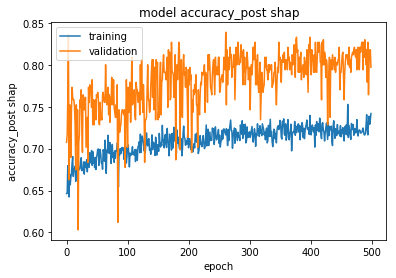

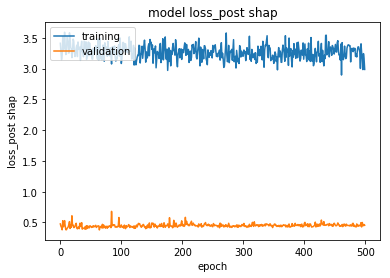

In [358]:
history1 = LossHistory()
hiss1 = model.fit(X_train1, y_train, epochs=500, batch_size=32,
                callbacks=[history1],
                validation_data=(X_test1,y_test), verbose=2)
score1 = model.evaluate(X_test1, y_test, batch_size=64)
print(score1)
plt.plot(hiss1.history['acc'])
plt.plot(hiss1.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss1.history['loss'])
plt.plot(hiss1.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test1)

PCA:
-------

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [ ]:
pca.fit(X)

In [ ]:
pca.n_components_

In [ ]:
winter_pca = pca.transform(X)

In [ ]:
winter_pca.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(winter_pca, y, test_size=0.15, shuffle=True)

In [ ]:
X_trainw.shape